In [163]:
from __future__ import division, print_function
import numpy as np
from random import randint
import cv2
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Arc, Arrow, Circle, CirclePolygon, Ellipse, Rectangle, Wedge

from learning2learn.images import rearrange_points

In [ ]:
class Texture():
    """
    TODO
    """
    def __init__(self, shape, size, frequency, color):
        self.shape = shape
        self.size = size
        self.

In [8]:
def generate_random_shape(x_min, x_max, y_min, y_max, x_offset, y_offset):
    """

    :param x_min:
    :param x_max:
    :param y_min:
    :param y_max:
    :param x_offset:
    :param y_offset:
    :return:
    """
    x = np.random.uniform(x_min, x_max - x_offset)
    y = np.random.uniform(y_min, y_max - y_offset)
    points = [(np.random.uniform(x, x + x_offset),
               np.random.uniform(y, y + y_offset)) for _ in
              range(randint(3, 10))]
    points = rearrange_points(points)
    return points

In [3]:
def generate_image(shape, color, texture, save_file=None):
    """

    :param shape:
    :param color:
    :param texture:
    :param save_file:
    :return:
    """
    # Plot figure
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    # Lay the baseline color
    polygon = Polygon(shape, closed=True, fill=True, color=color)
    obj = ax.add_patch(polygon)
    # Lay the texture hatch
    polygon_h = Polygon(shape, closed=True, fill=False, color=(0, 0, 0))
    obj_h = ax.add_patch(polygon_h)
    obj_h.set_hatch(texture)
    plt.ylim([-2,2])
    plt.xlim([-2,2])
    plt.axis('off')
    plt.show()
    #fig.savefig(save_file)

In [30]:
shape = generate_random_shape(-2, 2, -2, 2, 4, 4)
color = np.random.uniform(0, 1, size=3)

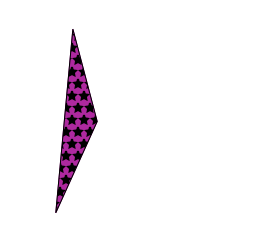

In [4]:
mpl.rcParams['hatch.linewidth'] = 2
texture = '*'
generate_image(shape, color, texture)

In [131]:
def get_gradient_img(height, width, color, gradient=None):
    img = np.zeros(shape=(height, width, 3))
    if gradient is None:
        # no gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color
    elif gradient is 'right':
        # rightward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(j/height)
    elif gradient is 'left':
        # leftward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(1 - j/height)
    elif gradient is 'up':
        # upward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(1 - i/width)
    elif gradient is 'down':
        # downward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(i/width)
    else:
        raise Exception("'gradient' must be one of ['right', 'left', 'up', or 'down'].")
    
    return img

In [126]:
color = np.random.uniform(0, 1, size=3)

In [164]:
img = get_gradient_img(500, 500, color)

In [340]:
class Texture(object):
    def __init__(self, patch_type, params):
        assert patch_type in [
            'ellipse', 'arc', 'arrow', 'circle',
            'rectangle', 'wedge', 'circle_polygon5',
            'circle_polygon6', 'circle_polygon7', 
            'circle_polygon8'
        ]
        self.patch_type = patch_type
        self.params = params
        
    def get_patch(self, xy):
        if self.patch_type == 'circle':
            return Circle(
                xy, self.params['radius'],
                color='black'
            )
        elif self.patch_type == 'rectangle':
            return Rectangle(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type == 'ellipse':
            return Ellipse(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type == 'arc':
            return Arc(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type.startswith('circle_polygon'):
            resolution = int(self.patch_type[-1])
            return CirclePolygon(
                xy, self.params['radius'],
                resolution,
                color='black'
            )
        elif self.patch_type == 'wedge':
            return Wedge(
                xy, self.params['radius'], 0,
                self.params['theta2'],
                color='black'
            )
        elif self.patch_type == 'arrow':
            x, y = xy
            return Arrow(
                x, y, self.params['dx'],
                self.params['dy'],
                self.params['width'],
                color='black'
            )

def add_texture(ax, patch_type, image_size=500):
    assert patch_type in [
        'ellipse', 'arc', 'arrow', 'circle',
        'rectangle', 'wedge', 'circle_polygon5',
        'circle_polygon6', 'circle_polygon7', 
        'circle_polygon8'
    ]
    # Patch size will be uniformly sampled. Let's define
    # reasonable boundaries here
    patch_min_size = int(0.02*image_size)
    patch_max_size = int(0.07*image_size)
    # Step size (space between patches) will also be 
    # uniformly sampled. Define boundaries here
    step_min_size = int(0.15*image_size)
    step_max_size = int(0.3*image_size)
    # Now, build the texture object according to the specified type
    if patch_type == 'circle':
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size)
        }
    elif patch_type in ['rectangle', 'ellipse', 'arc']:
        params = {
            'height': np.random.randint(patch_min_size, patch_max_size),
            'width': np.random.randint(2*patch_min_size, 2*patch_max_size),
            'angle': np.random.randint(0, 181)
        }
    elif patch_type.startswith('circle_polygon'):
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size),
        }
    elif patch_type == 'wedge':
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size),
            'theta2': np.random.randint(0, 271)
        }
    elif patch_type == 'arrow':
        params = {
            'dx': np.random.randint(-patch_max_size, patch_max_size),
            'dy': np.random.randint(-patch_max_size, patch_max_size),
            'width': np.random.randint(3*patch_min_size, 3*patch_max_size)
        }
    
    # Now create the texture object instance
    texture = Texture(patch_type, params)
    
    # Now sample the step size and step through the image
    # placing the patches at different locations, 'step'
    # pixels apart from one another
    step = np.random.randint(step_min_size, step_max_size)
    for i in range(10, 2*image_size, step):
        for j in range(10, 2*image_size, step):
            patch = texture.get_patch((i,j))
            ax.add_patch(patch)

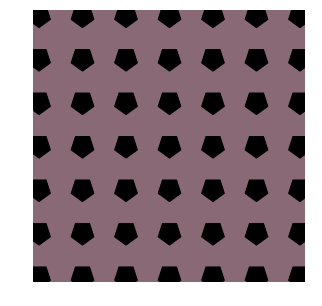

In [355]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.set_aspect('equal')
ax.imshow(
    img,
    interpolation='bicubic'
)
add_texture(ax, 'circle_polygon5')
#ax.add_patch(Arrow(250, 250, 20, 35, 150))
ax.axis('off')
plt.show()

In [13]:
# original image
# -1 loads as-is so if it will be 3 or 4 channel as the original
image = cv2.imread('/Users/reubenfeinman/Desktop/apple.jpg', -1)
print(image.shape)

(1204, 1595, 3)


In [28]:
# mask defaulting to black for 3-channel and transparent for 4-channel
# (of course replace corners with yours)
mask = np.zeros(image.shape, dtype=np.uint8)
# sample corners of polygon mask
shape = generate_random_shape(x_min=0, x_max=1204, y_min=0, y_max=1595, x_offset=1000, y_offset=1000)
roi_corners = np.array([shape], dtype=np.int32)
# fill the ROI so it doesn't get wiped out when the mask is applied
channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
ignore_mask_color = (255,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)
# from Masterfool: use cv2.fillConvexPoly if you know it's convex

# apply the mask
masked_image = cv2.bitwise_and(image, mask)

# save the result
cv2.imwrite('/Users/reubenfeinman/Desktop/image_masked.png', masked_image)

True